# Measure invariance to rotations in a pretrained ResNet 18 model

Using PyTorch, we will download a ResNet 18 model pretrained on ImageNet and evaluate its invariance to brightness transformations.


First, we install the `tmeasures` library. Then, we also define the compute device (`cuda` if available, `cpu` if not) and the path to store data and results.

You should have previously installed `torch` and `torchvision` with the appropriate versions for your hardware/os. If unsure, you can run `%pip install torch torchvision` in a notebook cell, but be aware the installed versions may not be able to use GPU/TPU acceleration depending on your stack. You can explore more specific PyTorch versions in [their website](https://pytorch.org/get-started/locally/)






In [ ]:
%pip install tmeasures 
%pip install tinyimagenet
%pip install scikit-learn

%load_ext autoreload
%autoreload 2
import torch 

from pathlib import Path


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_path = Path("~/tm_example_pytorch/").expanduser()
results_path.mkdir(parents=True, exist_ok=True)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 6.5 MB/s eta 0:00:00m eta 0:00:010:00:01
Defaulting to user installation because normal site-packages is not writeable
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import pretrained model

In this case we will use a ResNet 18 model pretrained on the full ImageNet dataset. 



In [6]:
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


# Measure model's invariance  to rotations

To measure the model's invariance, we require three things:

1. A version of the dataset, without labels and reduced in size to reduce computation.
2. A discrete and finite set of transformations 
3. The model itself, with access to intermediate values or activations

Afterwards, we can create an Invariance Measure and compute it with these elements.

# 1. Dataset

Since the invariance measure do not use the labels of the dataset, we will create a custom TinyImageNet dataset which does not return labels, only samples.

Also, since the invariance measure does not require large sample sizes, we will subsample the test set of mnist to obtain a reduced sample and reduce computation time.



In [7]:

import tinyimagenet
import torchvision

class TinyImageNet(tinyimagenet.TinyImageNet):
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        return x

normalize_transform = torchvision.transforms.Compose(
    [
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(TinyImageNet.mean,TinyImageNet.std),
     ])


dataset_nolabels = TinyImageNet(root="~/.datasets/tinyimagenet/",split="test", transform=normalize_transform)


# Subsample 
N = 1000
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
indices, _ = train_test_split(np.arange(len(dataset_nolabels)), train_size=N, stratify=dataset_nolabels.targets,random_state=0)
dataset_nolabels = Subset(dataset_nolabels, indices)



100%|██████████| 248100043/248100043 [04:08<00:00, 1000083.08it/s]


Extracting /home/facundoq/.datasets/tinyimagenet/tiny-imagenet-200.zip to /home/facundoq/.datasets/tinyimagenet


# 2. Transformations

`torchvision.transforms` provides classes with ready-made and infinite random sets of transformations such as `ColorJitter`. However, these cannot be used by the `TMeasures` library, since it needs a _finite_ set of transformations. 

In this case, we will define a set of 8 simple brightness transformations, that increase or decrease brightness by some factor, by using `torchvision.transforms.functional.adjust_brightness`. 


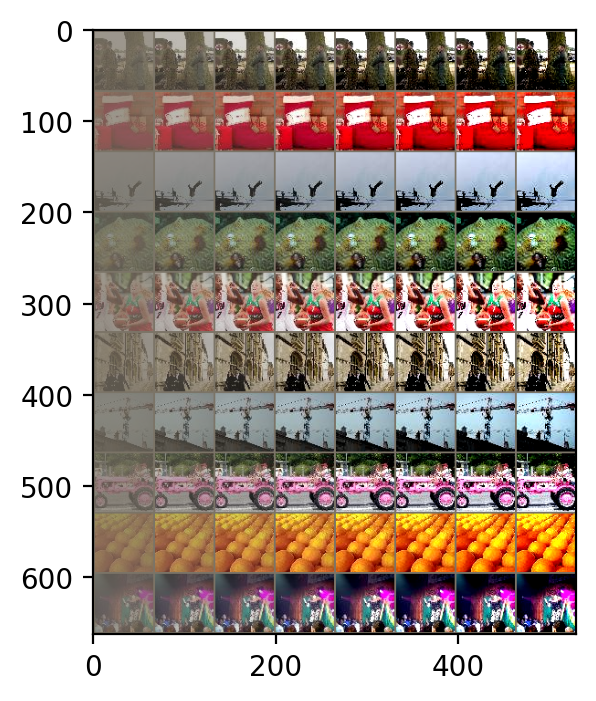

In [17]:
import torchvision
import math

def brightness_transform(brightness_factor:float):
    #return lambda x: torchvision.transforms.functional.adjust_brightness(x,brightness_factor)
    return lambda x: x*brightness_factor

transformations = [brightness_transform(factor) for factor in [0.25,0.5,0.75,1,1.25,1.50,1.75,2.0]]

n=500
step = 50
transformed_images = [ t(dataset_nolabels[i]) for i in range(0,n,step) for t in transformations]
grid = torchvision.utils.make_grid(transformed_images)

import matplotlib.pyplot as plt
grid_np = grid.permute(1,2,0).numpy()
grid_np = grid_np * np.array(TinyImageNet.std)+np.array(TinyImageNet.mean)
plt.figure(dpi=200)
plt.imshow(grid_np)


# 3. Model

PyTorch works with `nn.Module` objects that provide a `forward` method. The invariance measures, however, do not require just the result(s) of the `forward` method. Instead, we need the result of all the intermediate values or activations used to compute the final output(s). 

While it would be possible to modify a `nn.Module` defined model to return all of its activations, this would be cumbersome and difficult to manage since when training/testing we would require the *usual* `forward`, and when computing the measure we would require the new `forward`.

Therefore, measures in `tmeasures` require a model that implements the `ActivationsModule` interface with just two methods: `forward_activations` and `activation_names`. While implementing these methods allow you to best decide which activations are selected and how they are used, they can be cumbersome to define and mantain, specially when actively modifying a model.

Luckily, the `AutoActivationsModule` can take an unmodified `nn.Module` and automatically implement these methods using [forward hooks](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html).




In [20]:
import tmeasures as tm


# Put the model in evaluation mode
model.eval()
print(model)


# Create an ActivationsModule from the vanilla model
activations_module = tm.pytorch.AutoActivationsModule(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Computing the measure

Last step before computing the measure: we need to define a PyTorchMeasureOptions object to configure where and the measure will be computed. The `batch_size` and `num_workers` keywords are analogous to the ones used in [PyTorch's DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). 

The `data_device`, `model_device` and `measure_device`   indicate, respectively, where the transformations and data preprocessing is performed, where the activations of the model are computed, and finally where the actual measure is computed. In simple cases, these devices could all be the same.

Finally, we can `eval` the measure with the dataset, transformation, model and options, obtaining a `PyTorchMeasureResult`, which can be handily converted to a `numpy` version for easy visualization.


In [19]:
# Define options for computing the measure
options = tm.pytorch.PyTorchMeasureOptions(batch_size=128, num_workers=0,model_device=device,measure_device=device,data_device="cpu")

# Define the measure and evaluate it
measure = tm.pytorch.NormalizedVarianceInvariance()
measure_result:tm.pytorch.PyTorchMeasureResult = measure.eval(dataset_nolabels,transformations,activations_module,options)
measure_result = measure_result.numpy()

  0%|          | 0/2 [00:18<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
tm.visualization.plot_average_activations(measure_result)
plt.show()
tm.visualization.plot_heatmap(measure_result)
